In [1]:
import os
import glob
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import ImageGrid, make_axes_locatable, Size, Divider

In [2]:
file_names = glob.glob('/mnt/c/Users/conor/OneDrive/Desktop/temp_extraction_new/*')

annotations = dict()

for file_name in tqdm(file_names):
    for i in [1,2]:
        try:
            annotations[f"{file_name.split('/')[-1][:-4]}"] = matplotlib.image.imread(f"/mnt/c/Users/conor/Google Drive/PHD/Project with Janet/Label_Images/TMA_{i}/{file_name.split('/')[-1][:-4]}.png")  
            continue

        except FileNotFoundError as e:

            pass
            #print(f'{file_name} not found')

In [3]:
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, FunctionTransformer, normalize

In [4]:
master = pd.read_excel('./master_xl.xlsx')

In [7]:
gb = list(master.groupby('REF'))

TMA_1_C3


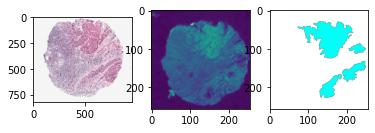

In [64]:
row = gb[16]

name = row[0]
print(name)

df1 = row[1].iloc[0,:]

ftir = pd.read_hdf(df1['FTIR'], key='Data')

ann = matplotlib.image.imread('/mnt/c/Users/conor/Google Drive/PHD/Project with Janet/Label_Images/TMA_1/TMA_1.1_C3.png')

he1 = matplotlib.image.imread(df1['HE'])
he2 = matplotlib.image.imread(df2['HE'])

fig, axes = plt.subplots(ncols=3, figsize=())
axes[0].imshow(he1)
axes[1].imshow(ftir.values.reshape(256,256,-1)[:,:,195])
axes[2].imshow(ann)


In [129]:
row = gb[114]

name = row[0]
print(name)

df1 = row[1].iloc[0,:]

try: df2 = row[1].iloc[1,:]
except: df2 = row[1].iloc[0,:]

ftir = pd.read_hdf(df1['FTIR'], key='Data')

try:
    ann = matplotlib.image.imread(df1['ANN'])
except:
    ann = np.random.random((10,10))

he1 = matplotlib.image.imread(df1['HE'])
he2 = matplotlib.image.imread(df2['HE'])

cluster_annotations([ftir, ann, he1, he2], 2, name, imsize=6)

IndexError: list index out of range

In [8]:
def cluster_annotations(images, nk, ref, imsize=4, mask=None):

    fig, axes = plt.subplots(ncols=5, figsize=(5*imsize,imsize))
    [ax.set_xticks([]) for ax in axes]
    [ax.set_yticks([]) for ax in axes]

    cubedf, ann, he1, he2 = images

    fig.suptitle(ref, size=20)

    # Amide slice which to overwrite with new annotation
    cube_s = cubedf.values.reshape(256,256,-1)[:,:,195]
    pipe = Pipeline([('Scaler', StandardScaler()), ('PCA', PCA(0.9)), ('Cluster', KMeans(nk, random_state=1))])

    if mask is None:

        y = pipe.fit_transform(images[0])
        im_km = y.argmin(axis=1).reshape(256,256)

        nc = 2
        cr = np.arange(nc)

    else:

        y = pipe.fit_transform(images[0].values[mask.flatten()])
        im_km = cube_s.copy().flatten()
        im_km[mask.flatten()] = y.argmin(axis=1)
        im_km[~mask.flatten()] = -1
        im_km = im_km.reshape(256,256)

        nc = nk+1
        cr = np.arange(-1, nc)


    axim = axes[0].imshow(im_km, cmap = matplotlib.cm.get_cmap('Paired_r', nc), aspect='auto',interpolation=None)
    divider = make_axes_locatable(axes[0])
    cax  = divider.append_axes("right", size="15%", pad=0.05)
    cbar = plt.colorbar(axim, cax=cax)
    tick_locs = (np.arange(nc) + 0.5)*((nc-1)/nc)
    cbar.set_ticks(tick_locs)
    cbar.set_ticklabels(np.arange(nc))

    axes[1].set_aspect('equal')
    axes[1].imshow(he1)
    axes[2].imshow(he2)
    axes[3].imshow(ann)
    axes[4].imshow(cubedf.values.reshape(256,256,-1)[:,:,195])
    plt.show()

    sv = input("Save? (y/n)").lower()

    if sv == 'n':
        
        sel = int(input("Select which area?"))
        nk = int(input("How many clusters?"))
        
        #mask = np.where(y.argmin(axis=1) == sel)[0]
        mask = (y.argmin(axis=1) == sel)
        mask = (axim._A==sel)
        print(mask.shape)

        print(f'Area: {sel} \tN clusters: {nk}')

        cluster_annotations(images, nk, ref, mask=mask, imsize=imsize)

    else:

        svsel = np.array([int(area) for area in input("Select which area(s)?").split(',')])
        mask = (y.argmin(axis=1) == svsel)
        mask = (axim._A == svsel)

        output = images[0].iloc[mask.flatten(),:]

        dir = f'./masks_1805/{ref}'

        try:
            os.mkdir(dir)
        except:
            pass
        output.to_hdf(dir + f'/{ref}.hdf', key='Data')

        plt.imshow(mask, cmap='gray')
        plt.imsave(dir + f'/{ref}_mask.png', mask, cmap='gray')
